In [267]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
import statsmodels.api as sm
import matplotlib.pyplot as plt

import anndata2ri
import rpy2.robjects as robjects
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [71]:
%R BiocManager::install("scRNAseq")

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://mirror.las.iastate.edu/CRAN

R[write to console]: Bioconductor version 3.18 (BiocManager 1.30.21), R 4.3.1 (2023-06-16 ucrt)

R[write to console]: Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.3.1/library
  packages:
    boot, cluster, foreign, KernSmooth, nlme, rpart, spatial, survival

R[write to console]: Old packages: 'annotate', 'AnnotationDbi', 'aod', 'apeglm', 'ashr', 'askpass',
  'AUCell', 'basilisk', 'basilisk.utils', 'batchelor', 'bbmle', 'bdsmatrix',
  'beachmat', 'BH', 'BiasedUrn', 'Biobase', 'BiocFileCache', 'BiocGenerics',
  'BiocIO', 'BiocManager', 'BiocNeighbors', 'BiocParallel', 'BiocSingular',
  'BiocVersion', 'biocViews', 'biomaRt', 'Biostrings', 'bluster', 'brew',
  'brio', 'bslib', 'Cairo', 'callr', 'checkmate', 'circlize', 'cla

Update all/some/none? [a/s/n]: 

'scRNAseq'


In [72]:
%R suppressPackageStartupMessages(library(scRNAseq))

'scRNAseq','SingleCe...,'Summariz...,...,'datasets','methods','base'


In [73]:
%%R -o adata_zeisel

adata_zeisel = ZeiselBrainData()

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

R[write to console]: snapshotDate(): 2023-10-24

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: downloading 1 resources

R[write to console]: retrieving 1 resource

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                  

R[write to console]: loading from cache

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: downloading 1 resources

R[write to console]: retrieving 1 resource

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 



R[write to console]: loading from cache

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: downloading 1 resources

R[write to console]: retrieving 1 resource

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 



R[write to console]: loading from cache

R[write to console]: snapshotDate(): 2023-10-24

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: downloading 1 resources

R[write to console]: retrieving 1 resource

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 



R[write to console]: loading from cache

c:\Users\dante\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
c:\Users\dante\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [78]:
adata_zeisel.var['mt'] = adata_zeisel.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'

In [79]:
sc.pp.calculate_qc_metrics(adata_zeisel, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [394]:
from sklearn.exceptions import ConvergenceWarning
import warnings

def mixture_model(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt", plot=True):
    metrics = adata.obs #extract obs from anndata
    X = metrics[[detected, subsets_mito_percent]].values #store the values we want to use for mixture models

    bgmm = BayesianGaussianMixture(n_components=2, covariance_type="full", random_state=42) #initialize the mixture model
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            bgmm.fit(X)
    except ConvergenceWarning:
        raise ValueError("Initialization did not converge. ") #this will raise error if number of components cannot converge. Mixture model may not be appropriate

    return(bgmm)


In [623]:
def plot_model(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt"):
    metrics = adata.obs
    X = metrics[[detected, subsets_mito_percent]].values
    model = mixture_model(adata)

    posterior_probs = model.predict_proba(X)
    
    prob_compromised = posterior_probs[:, 1]
    prob_intact = posterior_probs[:, 0]

    # Set the probability threshold for cells to keep

    # Create a new DataFrame with probability metrics
    metrics = pd.DataFrame({
        'n_genes_by_counts': current_data['n_genes_by_counts'],
        'pct_counts_mt': current_data['pct_counts_mt'],
        'prob_compromised': prob_compromised
    })

    # Create scatter plot with probability estimates as colors
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=metrics, x='n_genes_by_counts', y='pct_counts_mt', hue='prob_compromised', ax=ax, palette='viridis')
    sns.kdeplot(data=metrics, x='n_genes_by_counts', y='pct_counts_mt', ax=ax, fill=True, cmap='Reds', alpha=0.3)
    
    ax.legend().remove()
    
    # Add colorbar with 'viridis' cmap
    for_cbar = plt.cm.ScalarMappable(cmap="viridis")
    for_cbar.set_array([])
    cbar = plt.colorbar(for_cbar, ax=ax, cmap='viridis')
    cbar.ax.set_ylabel('Probablity Compromised', rotation=270, labelpad=15)
    ax.set_xlabel("Detected Genes")
    ax.set_ylabel("Percent Mito")
    ax.set_title('Scatter Plot with BGMM Clustering')
    plt.show()

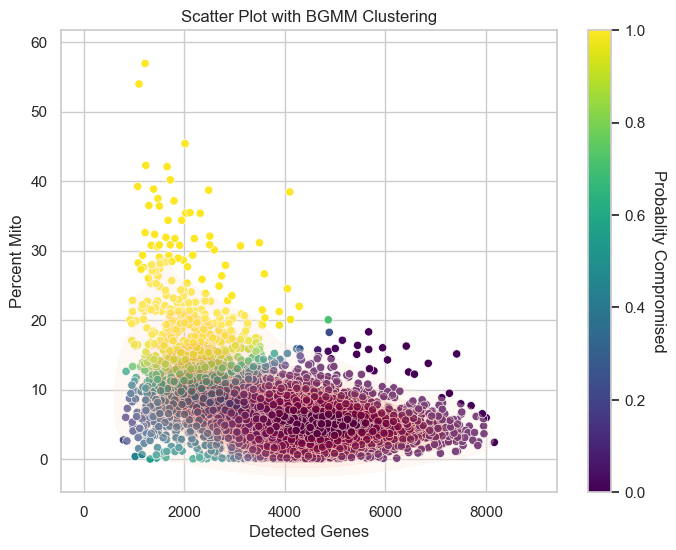

In [624]:
plot_model(adata_zeisel)

In [625]:
def plotfiltering(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt", threshold=0.75):
    metrics = adata.obs
    X = metrics[[detected, subsets_mito_percent]].values
    model = mixture_model(adata)

    posterior_probs = model.predict_proba(X)
    
    prob_compromised = posterior_probs[:, 1]
    prob_intact = posterior_probs[:, 0]

    # Set the probability threshold for cells to keep

    keep = prob_compromised <= threshold

    # Create a new DataFrame with probability metrics
    metrics = pd.DataFrame({
        'n_genes_by_counts': current_data['n_genes_by_counts'],
        'pct_counts_mt': current_data['pct_counts_mt'],
        'prob_compromised': prob_compromised,
        'keep': keep
    })

    # Create a GLM to predict 'pct_counts_mt' from 'n_genes_by_counts'
    X_glm = sm.add_constant(metrics['n_genes_by_counts'])
    y_glm = metrics['pct_counts_mt']
    glm_model = sm.GLM(y_glm, X_glm, family=sm.families.Gaussian())
    glm_results = glm_model.fit()

    # Extract the predicted values from the GLM
    predictions = glm_results.predict(X_glm)
    metrics['intact_prediction'] = predictions
    #here we are going to filter high probabiliy cells that have low mito content based on the GLM model
    metrics.loc[metrics['pct_counts_mt'] < metrics['intact_prediction'], 'keep'] = True

    min_discard = min(metrics[~metrics['keep']]['pct_counts_mt'])
    min_index = metrics[metrics['pct_counts_mt'] == min_discard].index[0]
    lib_complexity = metrics.loc[min_index]['n_genes_by_counts']
    metrics.loc[(metrics['n_genes_by_counts'] <= lib_complexity) & (metrics['pct_counts_mt'] >= min_discard), 'keep'] = False

    # Create scatter plot with probability estimates as colors
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=metrics, x='n_genes_by_counts', y='pct_counts_mt', hue='keep', ax=ax)
    
    ax.set_xlabel("Detected Genes")
    ax.set_ylabel("Percent Mito")
    ax.set_title('Scatter Plot with BGMM Clustering')
    plt.show()

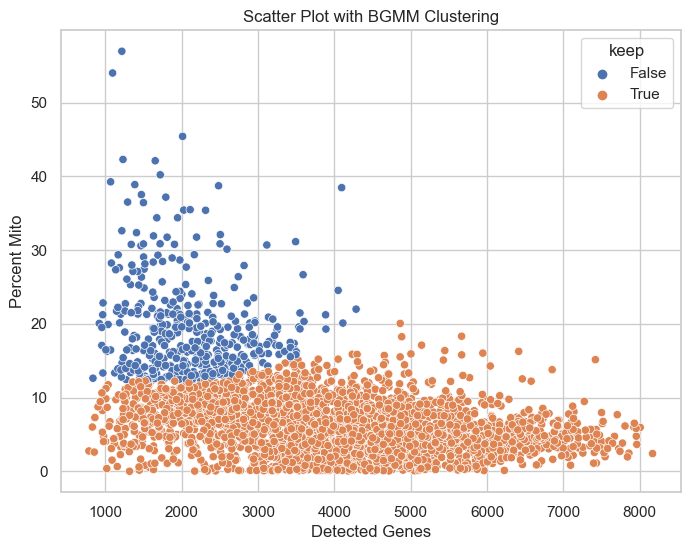

In [626]:
plotfiltering(adata_zeisel, threshold=0.75)